In [1]:
import xarray as xr
import pandas as pd
data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=False)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=False)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=False)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=False)
data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=False)
data_sun = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Sun\*.nc", parallel=False)
data_frost = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Frost\*.nc", parallel=False)
data_psl = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_psl\*.nc", parallel=False)
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=False)

In [2]:
import numpy as np

rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

min_length = len(wind)
rain = rain[:min_length]
hurs = hurs[:min_length]
temp = temp[:min_length]
temp_max = temp_max[:min_length]
temp_min = temp_min[:min_length]
sun = sun[:min_length]
frost = frost[:min_length]
wind = wind[:min_length]
psl = psl[:min_length]

In [3]:
import torch 

land_mask = ~np.isnan(temp)
land_mask_torch = torch.from_numpy(land_mask.astype(bool)) 

print(temp.shape)
print(land_mask.shape)

(648, 112, 82)
(648, 112, 82)


In [4]:
from skimage import measure

# Connected components labeling
labels = measure.label(land_mask)
biggest_component_label = np.argmax(np.bincount(labels.flat)[1:]) + 1  

# Isolate the biggest component
main_landmass_mask = (labels == biggest_component_label) 

# Get indices for bounding box
nonzero_indices = main_landmass_mask.nonzero()
min_row = np.min(nonzero_indices[1])
max_row = np.max(nonzero_indices[1])
min_col = np.min(nonzero_indices[2])
max_col = np.max(nonzero_indices[2])

In [5]:
rain = rain[:, min_row:max_row + 1, min_col:max_col + 1]
hurs = hurs[:, min_row:max_row + 1, min_col:max_col + 1]
temp = temp[:, min_row:max_row + 1, min_col:max_col + 1]
temp_max = temp_max[:, min_row:max_row + 1, min_col:max_col + 1]
temp_min = temp_min[:, min_row:max_row + 1, min_col:max_col + 1]
sun = sun[:, min_row:max_row + 1, min_col:max_col + 1] 
frost = frost[:, min_row:max_row + 1, min_col:max_col + 1] 
psl = psl[:, min_row:max_row + 1, min_col:max_col + 1] 
wind = wind[:, min_row:max_row + 1, min_col:max_col + 1] 
land_mask = land_mask[:, min_row:max_row + 1, min_col:max_col + 1]

In [6]:
nan_counts = np.count_nonzero(np.isnan(rain), axis=0)  # Counts across time

valid_grid_cell_mask = nan_counts == 0
valid_cell_indices = np.where(valid_grid_cell_mask)

# Your arrays from the previous output:
row_indices = valid_cell_indices[0]
col_indices = valid_cell_indices[1]

unique_rows, row_counts = np.unique(row_indices, return_counts=True)
unique_cols, col_counts = np.unique(col_indices, return_counts=True)

In [7]:
valid_row_indices = valid_cell_indices[0]  # Extract row indices
valid_col_indices = valid_cell_indices[1]  # Extract column indices

valid_rain_data = rain[:, valid_row_indices, valid_col_indices]
valid_temp_data = temp[:, valid_row_indices, valid_col_indices]
valid_wind_data = wind[:, valid_row_indices, valid_col_indices]
valid_hurs_data = hurs[:, valid_row_indices, valid_col_indices]
valid_psl_data = psl[:, valid_row_indices, valid_col_indices]
valid_frost_data = frost[:, valid_row_indices, valid_col_indices]
valid_sun_data = sun[:, valid_row_indices, valid_col_indices]
valid_tmax_data = temp_max[:, valid_row_indices, valid_col_indices]
valid_tmin_data = temp_min[:, valid_row_indices, valid_col_indices]

In [8]:
valid_rain_data = valid_rain_data[:,:1600].reshape(648, 64, 25)
valid_temp_data = valid_temp_data[:,:1600].reshape(648, 64, 25)
valid_wind_data = valid_wind_data[:,:1600].reshape(648, 64, 25)
valid_hurs_data = valid_hurs_data[:,:1600].reshape(648, 64, 25)
valid_psl_data = valid_psl_data[:,:1600].reshape(648, 64, 25)
valid_sun_data = valid_sun_data[:,:1600].reshape(648, 64, 25)
valid_frost_data = valid_frost_data[:,:1600].reshape(648, 64, 25)
valid_tmax_data = valid_tmax_data[:,:1600].reshape(648, 64, 25)
valid_tmin_data = valid_tmin_data[:,:1600].reshape(648, 64, 25)

In [9]:
nan_count_temp = np.isnan(valid_temp_data).sum()
nan_count_tmax = np.isnan(valid_tmax_data).sum()
nan_count_tmin = np.isnan(valid_tmin_data).sum()
nan_count_wind = np.isnan(valid_wind_data).sum()

print('Number of NaN values in Temp:', nan_count_temp)
print('Number of NaN values in Tmax:', nan_count_tmax)
print('Number of NaN values in Tmin:', nan_count_tmin)
print('Number of NaN values in Wind:', nan_count_wind)


def fill_nan_with_mean(data):
    col_mean = np.nanmean(data, axis=0)  # Calculate mean per column
    inds = np.where(np.isnan(data))
    data[inds] = np.take(col_mean, inds[1])  # Replace NaNs with mean
    return data

temp_filled = fill_nan_with_mean(valid_temp_data.copy())  
tmax_filled = fill_nan_with_mean(valid_tmax_data.copy())
tmin_filled = fill_nan_with_mean(valid_tmin_data.copy())
wind_filled = fill_nan_with_mean(valid_wind_data.copy())

nan_count_temp = np.isnan(temp_filled).sum()
nan_count_tmax = np.isnan(tmax_filled).sum()
nan_count_tmin = np.isnan(tmin_filled).sum()
nan_count_wind = np.isnan(wind_filled).sum()

print('Number of NaN values in Temp:', nan_count_temp)
print('Number of NaN values in Tmax:', nan_count_tmax)
print('Number of NaN values in Tmin:', nan_count_tmin)
print('Number of NaN values in Wind:', nan_count_wind)

Number of NaN values in Temp: 123
Number of NaN values in Tmax: 108
Number of NaN values in Tmin: 123
Number of NaN values in Wind: 167
Number of NaN values in Temp: 0
Number of NaN values in Tmax: 0
Number of NaN values in Tmin: 0
Number of NaN values in Wind: 0


In [17]:
rain = np.array(valid_rain_data)
temp = np.array(temp_filled)
hurs = np.array(valid_hurs_data)
frost = np.array(valid_frost_data)
sun = np.array(valid_sun_data)
wind = np.array(wind_filled)
psl = np.array(valid_psl_data)
temp_max = np.array(tmax_filled)
temp_min = np.array(tmin_filled)

In [18]:
# Arrays with all but the last time step
rain = rain[:-1]
temp = temp[:-1]
hurs = hurs[:-1]
frost = frost[:-1]
sun = sun[:-1]
wind = wind[:-1]
psl = psl[:-1]
temp_max = temp_max[:-1]
temp_min = temp_min[:-1]

# Arrays with only the last time step
rain_last = np.array([rain[-1]])
temp_last = np.array([temp[-1]])
hurs_last = np.array([hurs[-1]])
frost_last = np.array([frost[-1]])
sun_last = np.array([sun[-1]])
wind_last = np.array([wind[-1]])
psl_last = np.array([psl[-1]])
temp_max_last = np.array([temp_max[-1]])
temp_min_last = np.array([temp_min[-1]])

In [19]:
print('Rain', rain.shape)
print('Temp', temp.shape)
print('Hurs', hurs.shape)
print('Frost', frost.shape)
print('Sun', sun.shape)
print('Wind', wind.shape)
print('Psl', psl.shape)
print('Temp_max', temp_max.shape)
print('Temp_min', temp_min.shape)

print('Rain_last', rain_last.shape)
print('Temp_last', temp_last.shape)
print('Hurs_last', hurs_last.shape)
print('Frost_last', frost_last.shape)
print('Sun_last', sun_last.shape)
print('Wind_last', wind_last.shape)
print('Psl_last', psl_last.shape)
print('Temp_max_last', temp_max_last.shape)
print('Temp_min_last', temp_min_last.shape)


Rain (647, 64, 25)
Temp (647, 64, 25)
Hurs (647, 64, 25)
Frost (647, 64, 25)
Sun (647, 64, 25)
Wind (647, 64, 25)
Psl (647, 64, 25)
Temp_max (647, 64, 25)
Temp_min (647, 64, 25)
Rain_last (1, 64, 25)
Temp_last (1, 64, 25)
Hurs_last (1, 64, 25)
Frost_last (1, 64, 25)
Sun_last (1, 64, 25)
Wind_last (1, 64, 25)
Psl_last (1, 64, 25)
Temp_max_last (1, 64, 25)
Temp_min_last (1, 64, 25)


In [20]:
# Flatten the 3D arrays
rain_flat = rain.reshape(-1)
hurs_flat = hurs.reshape(-1)
temp_flat = temp.reshape(-1)
temp_max_flat = temp_max.reshape(-1)
temp_min_flat = temp_min.reshape(-1)
sun_flat = sun.reshape(-1)
frost_flat = frost.reshape(-1)
psl_flat = psl.reshape(-1)
wind_flat = wind.reshape(-1)

# Create a DataFrame containing all features
combined_data = pd.DataFrame({
    'Rain': rain_flat,
    'Hurs': hurs_flat,
    'Temp': temp_flat,
    'Temp_Max': temp_max_flat,
    'Temp_Min': temp_min_flat,
    'Sun': sun_flat,
    'Frost': frost_flat,
    'Psl': psl_flat,
    'Wind': wind_flat
})

In [21]:
df_filtered = combined_data 

In [22]:
df_filtered

,Rain,Hurs,Temp,Temp_Max,Temp_Min,Sun,Frost,Psl,Wind
0,126.147451,90.974516,7.942743,9.483172,6.529507,52.679074,4.993733,1011.305341,7.837565
1,135.781950,89.126366,8.190250,9.772596,6.601715,53.206094,8.241496,1011.004080,6.831000
2,136.153542,90.382016,7.702709,9.391944,6.083515,51.006741,8.111889,1011.190085,6.065469
3,146.281093,92.148919,7.530887,9.284392,5.920506,50.349402,10.444545,1011.223684,6.494661
4,131.803960,89.188032,7.908033,9.432582,6.403731,49.513828,7.012561,1011.116773,6.079681
...,...,...,...,...,...,...,...,...,...
1035195,42.766279,87.017083,5.296701,7.501148,3.233882,31.579992,1.542468,1003.769856,7.835265
1035196,81.019293,86.234686,5.613230,8.090245,3.116105,32.002231,5.025880,1004.553267,8.015427
1035197,88.345342,87.029295,5.232188,7.813384,2.736460,33.215027,5.079787,1004.659696,8.231047
1035198,70.261427,89.439863,5.287242,8.257364,2.409932,37.457241,5.318928,1004.865623,6.554580


In [23]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the data
scaler.fit(df_filtered)

# Transform the data
normalized_data = scaler.transform(df_filtered)

# Convert the normalized data back to a DataFrame
df_normalized = pd.DataFrame(normalized_data, columns=df_filtered.columns)

In [24]:
print(df_normalized.head)

<bound method NDFrame.head of              Rain      Hurs      Temp  Temp_Max  Temp_Min       Sun     Frost  \
0        0.666098  1.884848 -0.035654 -0.442236  0.525433 -0.959819 -0.547037   
1        0.824841  1.478736  0.018549 -0.387425  0.543564 -0.951189 -0.141654   
2        0.830963  1.754652 -0.088221 -0.459513  0.413449 -0.987205 -0.157832   
3        0.997829  2.142911 -0.125849 -0.479881  0.372519 -0.997969  0.133328   
4        0.759298  1.492287 -0.043255 -0.451817  0.493852 -1.011652 -0.295049   
...           ...       ...       ...       ...       ...       ...       ...   
1035195 -0.707727  1.015243 -0.615128 -0.817592 -0.302067 -1.305331 -0.977821   
1035196 -0.077453  0.843319 -0.545809 -0.706029 -0.331640 -1.298417 -0.543025   
1035197  0.043254  1.017926 -0.629256 -0.758461 -0.426965 -1.278556 -0.536296   
1035198 -0.254705  1.547624 -0.617199 -0.674380 -0.508953 -1.209087 -0.506447   
1035199 -0.393587  1.956580 -0.660679 -0.698840 -0.560858 -1.189006 -0.375570  

In [25]:
# Define the sequence length and number of samples
sequence_length = 12
num_samples = len(df_normalized) - sequence_length

# Sample random indices for input sequences
random_indices = np.random.choice(num_samples, num_samples, replace=False)

# Initialize lists to store input sequences and corresponding targets
input_sequences = []
targets = []

# Generate input sequences and targets
for i in random_indices:
    input_seq = df_normalized.iloc[i:i+sequence_length].values
    target = df_normalized.iloc[i+sequence_length].values
    input_sequences.append(input_seq)
    targets.append(target)

# Convert lists to numpy arrays
input_sequences = np.array(input_sequences)
targets = np.array(targets)

print("Input sequences shape:", input_sequences.shape)
print("Targets shape:", targets.shape)


Input sequences shape: (1035188, 12, 9)
Targets shape: (1035188, 9)


In [26]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(input_sequences, targets, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets (75% training, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Testing data shape:", X_test.shape, y_test.shape)


Training data shape: (621112, 12, 9) (621112, 9)
Validation data shape: (207038, 12, 9) (207038, 9)
Testing data shape: (207038, 12, 9) (207038, 9)


In [27]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define batch size
batch_size = 32

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [28]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        # Flatten the output of the last LSTM layer
        out = out[:, -1, :]

        # Forward pass through fully connected layer
        out = self.fc(out)
        return out


In [29]:

num_layers = 2
hidden_size = 64
input_size = 9
num_epochs = 20

model = LSTMModel(input_size=input_size,
                  hidden_size=hidden_size,
                  num_layers=num_layers,
                  output_size=input_size)

Epoch [1/20], Train Loss: 0.0740, Val Loss: 0.0628, Train R-squared: 0.9260, Val R-squared: 0.9372, Train MAE: 0.1486, Val MAE: 0.1362
Epoch [2/20], Train Loss: 0.0592, Val Loss: 0.0544, Train R-squared: 0.9408, Val R-squared: 0.9456, Train MAE: 0.1349, Val MAE: 0.1307
Epoch [3/20], Train Loss: 0.0505, Val Loss: 0.0467, Train R-squared: 0.9495, Val R-squared: 0.9533, Train MAE: 0.1285, Val MAE: 0.1256
Epoch [4/20], Train Loss: 0.0434, Val Loss: 0.0405, Train R-squared: 0.9566, Val R-squared: 0.9595, Train MAE: 0.1216, Val MAE: 0.1179
Epoch [5/20], Train Loss: 0.0381, Val Loss: 0.0361, Train R-squared: 0.9618, Val R-squared: 0.9639, Train MAE: 0.1156, Val MAE: 0.1124
Epoch [6/20], Train Loss: 0.0345, Val Loss: 0.0330, Train R-squared: 0.9655, Val R-squared: 0.9671, Train MAE: 0.1107, Val MAE: 0.1076
Epoch [7/20], Train Loss: 0.0319, Val Loss: 0.0320, Train R-squared: 0.9681, Val R-squared: 0.9680, Train MAE: 0.1069, Val MAE: 0.1058
Epoch [8/20], Train Loss: 0.0301, Val Loss: 0.0302, Tra

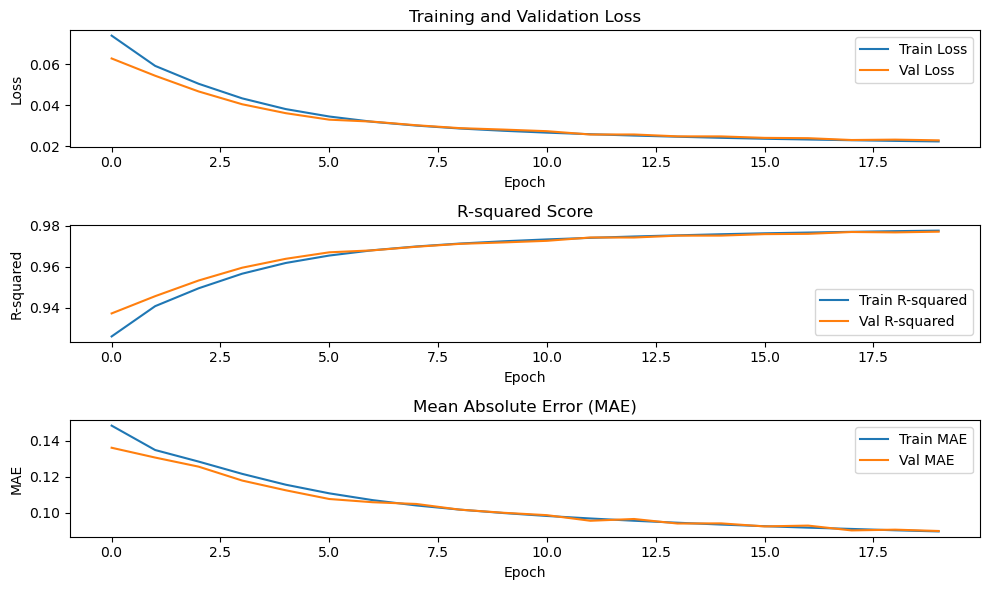

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import torch.optim as optim

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define device
device = torch.device( "cpu")

# Move model to appropriate device
model.to(device)

# Define lists to store training and validation metrics
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    y_true_train = []
    y_pred_train = []
    
    # Iterate over training data
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * inputs.size(0)

        # Record predictions and true values for R-squared and MAE
        y_true_train.extend(targets.cpu().numpy())
        y_pred_train.extend(outputs.detach().cpu().numpy())

    # Calculate average loss for training epoch
    epoch_loss_train = running_loss / len(train_loader.dataset)
    
    # Calculate R-squared and MAE for training
    train_r2 = r2_score(y_true_train, y_pred_train)
    train_mae = mean_absolute_error(y_true_train, y_pred_train)
    
    # Append training loss, R-squared, and MAE to lists
    train_losses.append(epoch_loss_train)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)

    # Validation
    model.eval()
    val_loss = 0.0
    y_true_val = []
    y_pred_val = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item() * inputs.size(0)
            y_true_val.extend(targets.cpu().numpy())
            y_pred_val.extend(outputs.cpu().numpy())
    val_loss /= len(val_loader.dataset)
    
    # Calculate R-squared and MAE for validation
    val_r2 = r2_score(y_true_val, y_pred_val)
    val_mae = mean_absolute_error(y_true_val, y_pred_val)
    
    # Append validation loss, R-squared, and MAE to lists
    val_losses.append(val_loss)
    val_r2_scores.append(val_r2)
    val_mae_scores.append(val_mae)

    # Print metrics for current epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss_train:.4f}, Val Loss: {val_loss:.4f}, Train R-squared: {train_r2:.4f}, Val R-squared: {val_r2:.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 6))

# Plot training and validation losses
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot R-squared
axes[1].plot(train_r2_scores, label='Train R-squared')
axes[1].plot(val_r2_scores, label='Val R-squared')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R-squared')
axes[1].set_title('R-squared Score')
axes[1].legend()

# Plot MAE
axes[2].plot(train_mae_scores, label='Train MAE')
axes[2].plot(val_mae_scores, label='Val MAE')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('MAE')
axes[2].set_title('Mean Absolute Error (MAE)')
axes[2].legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()



In [31]:
model.eval()
test_loss = 0.0
y_true_test = []
y_pred_test = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item() * inputs.size(0)
        y_true_test.extend(targets.cpu().numpy())
        y_pred_test.extend(outputs.cpu().numpy())

# Calculate test loss
test_loss /= len(test_loader.dataset)

# Calculate R-squared and MAE for test set
test_r2 = r2_score(y_true_test, y_pred_test)
test_mae = mean_absolute_error(y_true_test, y_pred_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test R-squared: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss: 0.0230
Test R-squared: 0.9771
Test MAE: 0.0898


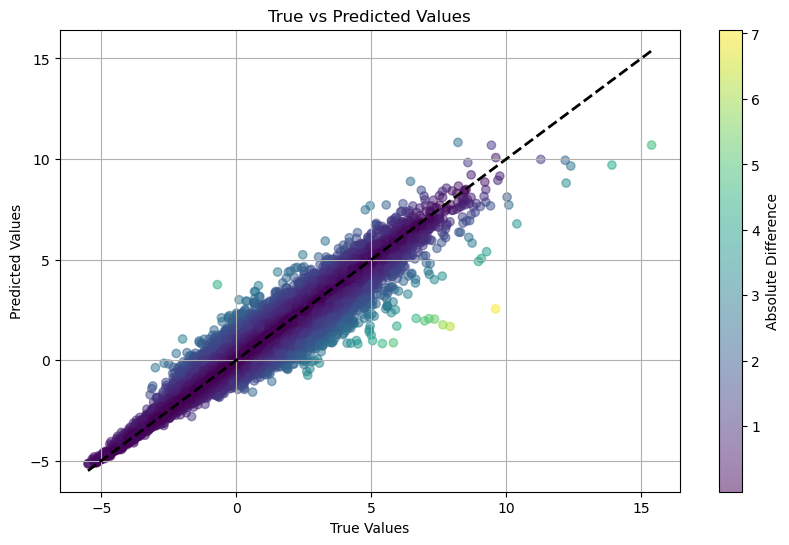

In [32]:
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)

abs_diff = np.abs(y_true_test - y_pred_test)

# Plot true vs predicted values with color-coded scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_true_test, y_pred_test, c=abs_diff, cmap='viridis', alpha=0.5)
plt.colorbar(label='Absolute Difference')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.plot([y_true_test.min(), y_true_test.max()], [y_true_test.min(), y_true_test.max()], 'k--', lw=2)  
plt.grid(True)
plt.show()


In [102]:
# Initialize a container to store the forecasts
forecasts = np.zeros(1600)  # Forecast only 1600 time steps

# Define the sequence length that the model was trained on
seq_length = 16000  # Replace with the actual sequence length

# Iterate over each unique location
for i in range(seq_length, 1600 + seq_length):
    # Extract a sequence of data
    data = df_normalized.iloc[i - seq_length:i, :].values
    
    # Convert to PyTorch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32)
    
    # Reshape for LSTM input (add batch and sequence length dimensions)
    data_tensor = data_tensor.unsqueeze(0)
    
    # Make forecast for one time step
    with torch.no_grad():
        forecast = model(data_tensor.to(device))  # Use only the last time step for forecasting
    
    # Extract the forecasted temperature
    forecast_temp = forecast.squeeze().cpu().numpy()[2]  # Assuming temperature is the third feature
    
    # Store the forecasted temperature
    forecasts[i - seq_length] = forecast_temp

In [95]:
forecasts.shape

(1600,)

In [96]:
forecasts = forecasts.reshape(1, 64, 25)
print(forecasts.shape)

(1, 64, 25)


In [97]:
forecasts_2d = forecasts.reshape(-1, 1)

# Reshape the data to 2D array
data_2d = df_filtered['Temp'].values.reshape(-1, 1)

# Fit the scaler on the original data
scaler.fit(data_2d)

# Now you can use it to revert the normalization
reverted_forecasts_2d = scaler.inverse_transform(forecasts_2d)

# Reshape the reverted data back to its original shape
reverted_forecasts = reverted_forecasts_2d.reshape(forecasts.shape)

In [98]:
reverted_forecasts.shape

(1, 64, 25)

In [99]:
reverted_forecasts

array([[[3.28360745, 4.92965755, 5.71759775, ..., 7.23806086,
         6.07107945, 6.87246902],
        [7.48386121, 7.83046826, 7.90742496, ..., 6.41955958,
         7.35823122, 7.2293775 ],
        [7.78647265, 8.35285158, 8.74488504, ..., 8.32584601,
         8.51737763, 8.30318384],
        ...,
        [5.20181514, 4.11793852, 3.9430551 , ..., 5.85793631,
         5.96799127, 6.76556758],
        [6.85052654, 5.72013385, 5.2406154 , ..., 6.48931475,
         5.91506298, 5.65270085],
        [5.8898064 , 5.87004061, 6.72868477, ..., 7.44974571,
         6.61178932, 7.1119807 ]]])

In [100]:
# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Actual_Temp': temp_last.flatten(),  # Flatten to make sure it's a 1D array
    'Predicted_Temp': reverted_forecasts.flatten()
})

# Display the DataFrame
print(comparison_df)

      Actual_Temp  Predicted_Temp
0        8.734846        3.283607
1        8.956846        4.929658
2        8.306932        5.717598
3        8.118835        6.603518
4        8.345772        7.094397
...           ...             ...
1595     5.296701        5.920731
1596     5.613230        6.726745
1597     5.232188        7.449746
1598     5.287242        6.611789
1599     5.088702        7.111981

[1600 rows x 2 columns]


In [101]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"Mean Squared Error: {mse}")

R-squared: -2.317174120937744
Mean Absolute Error: 1.7361134585848075
Mean Squared Error: 3.7147343884824697


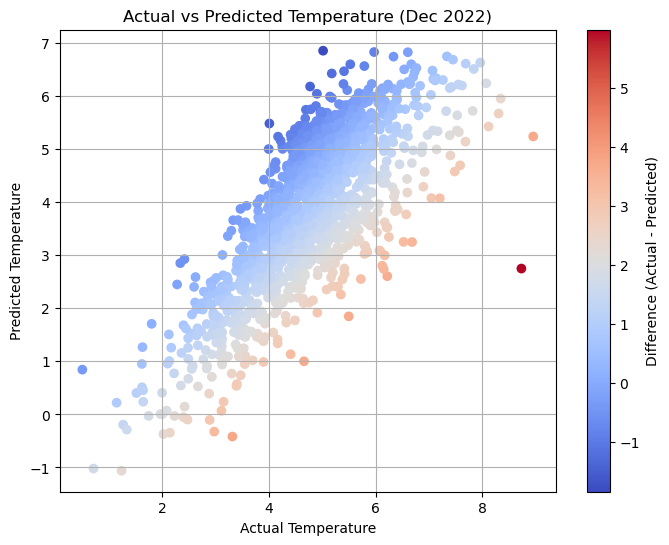

In [53]:
# Calculate the difference between actual and predicted temperature
comparison_df['Difference'] = comparison_df['Actual_Temp'] - comparison_df['Predicted_Temp']

# Create a scatter plot with a colormap representing the difference
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'], c=comparison_df['Difference'], cmap='coolwarm')

# Add labels and title
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Actual vs Predicted Temperature (Dec 2022)')

# Add colorbar
plt.colorbar(label='Difference (Actual - Predicted)')

# Show the plot
plt.grid(True)
plt.show()